In [1]:
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, TypeVar
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})
rc('lines', linewidth=5)
rc('text', usetex=True)

import cmasher as cmr

In [2]:
INPUT_DIR = OUTPUT_DIR = "/cmlscratch/jkirchen/watermarking-root/lm-watermarking-dev/figure_notebooks"
figure_dir = f"{INPUT_DIR}/figures"

# save = False
save = True

In [3]:
# enumerate data dir and load all csv files into a dataframe
def get_data_df(data_dir=None, data_path=None):

    data_df = pd.DataFrame()
    if data_path is None:
        for file in sorted(os.listdir(data_dir)):
            if file.endswith(".csv"):
                file_path = os.path.join(data_dir, file)
                data = pd.read_csv(file_path)
                data_df = data_df.append(data)
    else:
        data_df = pd.read_csv(data_path)

    return data_df

In [4]:

def plot_grouped_series_data(data_df, x_col="idx_T", y_col="avg", y_err_df=None, y_err_col=None, y_err_join_idx=None, x_name=None,y_name=None, x_lim=None, y_lim=None, limit_x_series=None, limit_x_series_map=None, solid_alpha=0.95, dash_style=":", dash_color="gray", dash_alpha=0.4, sortby="avg", series_id_col="id", series_readable_id_col="name", series_readable_id_map=None, special_color_map=None, title="Figure Title", legend_loc="upper left", grid=True, fig_size=(10, 6), save_path=None, show=True):

    # get unique series ids
    series_ids = data_df[series_id_col].unique()
    series_readable_ids = data_df[series_readable_id_col].unique()

    # check that can make a 1-1 mapping, i.e. the human readble names are unique and map to 1 series id
    assert len(series_readable_ids) == len(series_ids), "series_readable_ids is not a 1-1 mapping"
    print(series_readable_ids)

    # make human-readable series ids mapping
    series_readable_ids = data_df[[series_id_col, series_readable_id_col]].drop_duplicates().set_index(series_id_col).to_dict()[series_readable_id_col]

    if isinstance(series_readable_id_map, dict):
        series_readable_ids = {k:series_readable_id_map[v] for k,v in series_readable_ids.items()}
        print("Used dict tom map series_readable_ids")
    elif isinstance(series_readable_id_map, Callable):
        print(series_readable_ids.items())
        series_readable_ids = {k:series_readable_id_map(v) for k,v in series_readable_ids.items()}
        print("Used callable to map series_readable_ids")
    print(series_readable_ids)


    # set up figure
    fig, ax = plt.subplots(figsize=fig_size)


    ####################################
    # # Custom sorting and droping stuff
    # # sort by average y_col value in the series
    if sortby == "avg":
        sorted_series_ids = data_df.groupby(series_id_col)[y_col].mean().sort_values(ascending=False).index
    elif sortby == "mid":
        # sort by the middle value in each y_col series
        sorted_series_ids = data_df.groupby(series_id_col)[y_col].apply(lambda x: x.iloc[len(x)//2]).sort_values(ascending=False).index

    # trucate the series themselves if necessary
    if limit_x_series is not None: 
        # only keep up to limit_x_series points
        data_df = data_df[data_df[x_col] <= limit_x_series]

    
    # get a randomly dispersed colormap from cmr for these series
    # So that we can tell them apart
    cmap = cmr.take_cmap_colors("cmr.rainforest", len(sorted_series_ids), cmap_range=(0.2, 0.8), return_fmt="hex")

    ####################################
    legend_skip_mask = []
    # plot each series
    for i, series_id in enumerate(sorted_series_ids):
        if special_color_map and series_readable_ids[series_id] in special_color_map.keys():
            color = special_color_map[series_readable_ids[series_id]]
        else:
            color = cmap[i]

        series_df = data_df[data_df[series_id_col] == series_id]
        # ax.plot(series_df[x_col], series_df[y_col], label=series_readable_ids[series_id], color=COLORS[series_id], alpha=solid_alpha)
        # ax.plot(series_df[x_col], series_df[y_col], label=series_readable_ids[series_id])

        # limit this specfic series if necessary using the limit map
        if limit_x_series_map is not None and series_readable_ids[series_id] in limit_x_series_map.keys():
            # only keep up to the limit in the map for this name
            series_df = series_df[series_df[x_col] <= limit_x_series_map[series_readable_ids[series_id]]]

        # add std error bars if the col exists
        # ax.plot(series_df[x_col], series_df[y_col],  label=series_readable_ids[series_id], color=color, alpha=solid_alpha)
        if y_err_df is not None:
            #  plot the stderr col in the df matching it to the x_col in the series_df
            # get the error series that corresponds to the idx col values in the series_df
            y_err_subdf = y_err_df[y_err_df[series_id_col] == series_id]
            err_series = y_err_subdf[y_err_col]
            # err_series = y_err_subdf[y_err_subdf[y_err_join_idx].isin(y_err_subdf[y_err_join_idx])][y_err_col]
            ax.errorbar(series_df[x_col], series_df[y_col], yerr=err_series, label=series_readable_ids[series_id], color=color, alpha=0.1)
            
        ax.plot(series_df[x_col], series_df[y_col],  label=series_readable_ids[series_id], color=color, alpha=solid_alpha)
        legend_skip_mask.append(False)

        # if the series was limited, plot the rest as a dashed line in gray
        if limit_x_series_map is not None and series_readable_ids[series_id] in limit_x_series_map.keys():

            series_df = data_df[data_df[series_id_col] == series_id]
            # only keep after the limit in the map for this name
            series_df = series_df[series_df[x_col] >= limit_x_series_map[series_readable_ids[series_id]]]

            # do the same err plotting but with dashed lines
            if y_err_df is not None:
                #  plot the stderr col in the df matching it to the x_col in the series_df
                # get the error series that corresponds to the idx col values in the series_df
                y_err_subdf = y_err_df[y_err_df[series_id_col] == series_id]
                err_series = y_err_subdf[y_err_col]
                # err_series = y_err_subdf[y_err_subdf[y_err_join_idx].isin(y_err_subdf[y_err_join_idx])][y_err_col]
                # ax.errorbar(series_df[x_col], series_df[y_col], yerr=err_series, label=series_readable_ids[series_id], color=dash_color, alpha=0.1, linestyle=dash_style)
                ax.errorbar(series_df[x_col], series_df[y_col], yerr=err_series, label=series_readable_ids[series_id], color=color, alpha=0.1)

            ax.plot(series_df[x_col], series_df[y_col],  label=series_readable_ids[series_id], color=color, alpha=dash_alpha)
            legend_skip_mask.append(True)


    # set up legend, but exclude stderr if it's there
    handles, labels = ax.get_legend_handles_labels()
    print(handles)
    print(labels)
    if y_err_df is not None:
        # assume they're the first half
        handles = handles[:len(handles)//2]
        labels = labels[:len(labels)//2]

    # if series were limited and dashing occured, we need to remove the duplicates where a dashed was also added
    # we can do this by removing every element with a dash as the linestyle, zipped with labels
    if limit_x_series_map:
        # handles, labels = zip(*[(h,l) for h,l in zip(handles, labels) if h.get_linestyle() != dash_style])
        # print([h.get_linestyle() for h in handles])
        # filter based on the legend_skip_mask
        handles, labels = zip(*[(h,l) for h,l,skip in zip(handles, labels, legend_skip_mask) if not skip])
    
    ax.legend(handles, labels,loc=legend_loc, fontsize=12)
    
    # set up title
    ax.set_title(title)
    # label axes
    ax.set_xlabel(x_name if x_name else x_col)
    ax.set_ylabel(y_name if y_name else y_col)

    #set upper y_lim to 1
    ax.set_ylim(y_lim if y_lim else None)
    ax.set_xlim(x_lim if x_lim else None)

    # turn on grid
    ax.grid(grid)

    # tight
    fig.tight_layout()
    # save figure
    if save_path:
        # make if doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        if save_path.endswith(".pdf"):
            plt.savefig(save_path,format="pdf")
        elif save_path.endswith(".png"):
            plt.savefig(save_path,format="png")
    
    # show figure
    if show:
        plt.show()


In [5]:
def name_extractor(x):
    x = x.replace("no_wm_dipper_high_prefixes_eval", " Dipper")
    x = x.replace("no_wm_dipper_high_eval", " Dipper")
    x = x.replace("dipper_high_eval", " Dipper")
    x = x.replace("no_wm_gpt_p4_prefixes_eval", " GPT")
    x = x.replace("no_wm_gpt_p4_eval", " GPT")
    x = x.replace("gpt_p4_eval", " GPT")
    x = x.replace("prefixes", "")
    x = x.replace("core", "")
    x = x.replace("gen", "")
    x = x.replace("eval", "")
    x = x.replace("supp", "")
    x = x.replace("simple_1", "")
    x = x.replace("algorithm-3", "Algo3 ")

    x = x.replace("50_200", "")
    x = x.replace("100_600", "")
    x = x.replace("200_1000", "")
    
    x = x.replace("_", " ")
        
    x = x.replace("cp attack ", " CP-")

    return x.strip()


color_map = {k:i for i,k in enumerate(['Dipper', 'GPT', 'CP-1-25%', 'CP-3-25%', 'CP-3-10%', 'CP-1-10%'])}
cmap = cmr.take_cmap_colors("cmr.rainforest", len(color_map), cmap_range=(0.2, 0.8), return_fmt="hex")

color_map = {k:cmap[i] for k,i in color_map.items()}

In [6]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 20})

fig_name = "baseline_attacked_z_score_ROC_T_1000"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,fpr,id,name,tpr
0,10,0.000,cxiy1v63,core_simple_1_200_1000_dipper_high_eval,0.000000
1,10,0.000,cxiy1v63,core_simple_1_200_1000_dipper_high_eval,0.001923
2,10,0.000,cxiy1v63,core_simple_1_200_1000_dipper_high_eval,0.286538
3,10,0.000,cxiy1v63,core_simple_1_200_1000_dipper_high_eval,0.290385
4,10,0.000,cxiy1v63,core_simple_1_200_1000_dipper_high_eval,0.596154
...,...,...,...,...,...
1191,7,0.982,llq7qgr4,core_simple_1_200_1000_gen_cp_attack_3-10%_eval,0.998000
1192,7,0.982,llq7qgr4,core_simple_1_200_1000_gen_cp_attack_3-10%_eval,1.000000
1193,7,0.984,llq7qgr4,core_simple_1_200_1000_gen_cp_attack_3-10%_eval,1.000000
1194,7,0.992,llq7qgr4,core_simple_1_200_1000_gen_cp_attack_3-10%_eval,1.000000


['core_simple_1_200_1000_dipper_high_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'
 'core_simple_1_200_1000_gpt_p4_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval']
dict_items([('cxiy1v63', 'core_simple_1_200_1000_dipper_high_eval'), ('jtkisfd7', 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'), ('rzrpza5t', 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'), ('g2cs5tvw', 'core_simple_1_200_1000_gpt_p4_eval'), ('62luh543', 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'), ('llq7qgr4', 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval')])
Used callable to map series_readable_ids
{'cxiy1v63': 'Dipper', 'jtkisfd7': 'CP-3-25%', 'rzrpza5t': 'CP-1-25%', 'g2cs5tvw': 'GPT', '62luh543': 'CP-1-10%', 'llq7qgr4': 'CP-3-10%'}
[<matplotlib.lines.Line2D object at 0x7f87d1092b90>, <matplotlib.lines.Line2D object at 0x7f87d1092dd0>, <matplotlib.lines.Line2D object at 0x7f87d10924a

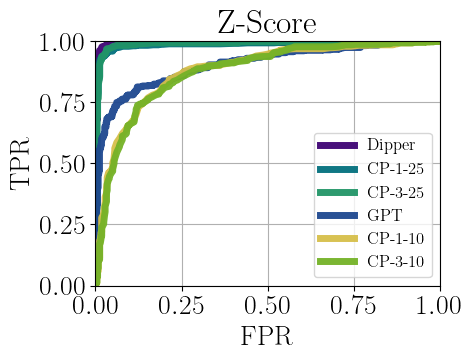

In [7]:
plot_grouped_series_data(
    data_df=df,
    x_col="fpr",
    y_col="tpr",
    x_name="FPR",
    y_name="TPR",
    x_lim=(0,1),
    y_lim=(0,1),
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    sortby="mid",
    special_color_map=color_map,
    legend_loc="lower right",
    title=f"Z-Score",
    fig_size=(5, 4),
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [8]:
fig_name = "baseline_attacked_winmax_ROC_T_1000"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,fpr,id,name,tpr
0,10,0.000,cxiy1v63,core_simple_1_200_1000_dipper_high_eval,0.000000
1,10,0.000,cxiy1v63,core_simple_1_200_1000_dipper_high_eval,0.001923
2,10,0.000,cxiy1v63,core_simple_1_200_1000_dipper_high_eval,0.611538
3,10,0.000,cxiy1v63,core_simple_1_200_1000_dipper_high_eval,0.615385
4,10,0.000,cxiy1v63,core_simple_1_200_1000_dipper_high_eval,0.657692
...,...,...,...,...,...
985,7,0.964,llq7qgr4,core_simple_1_200_1000_gen_cp_attack_3-10%_eval,0.998000
986,7,0.968,llq7qgr4,core_simple_1_200_1000_gen_cp_attack_3-10%_eval,0.998000
987,7,0.982,llq7qgr4,core_simple_1_200_1000_gen_cp_attack_3-10%_eval,1.000000
988,7,0.988,llq7qgr4,core_simple_1_200_1000_gen_cp_attack_3-10%_eval,1.000000


['core_simple_1_200_1000_dipper_high_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'
 'core_simple_1_200_1000_gpt_p4_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval']
dict_items([('cxiy1v63', 'core_simple_1_200_1000_dipper_high_eval'), ('jtkisfd7', 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'), ('rzrpza5t', 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'), ('g2cs5tvw', 'core_simple_1_200_1000_gpt_p4_eval'), ('62luh543', 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'), ('llq7qgr4', 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval')])
Used callable to map series_readable_ids
{'cxiy1v63': 'Dipper', 'jtkisfd7': 'CP-3-25%', 'rzrpza5t': 'CP-1-25%', 'g2cs5tvw': 'GPT', '62luh543': 'CP-1-10%', 'llq7qgr4': 'CP-3-10%'}
[<matplotlib.lines.Line2D object at 0x7f87c9405780>, <matplotlib.lines.Line2D object at 0x7f87c94058d0>, <matplotlib.lines.Line2D object at 0x7f87c9405b7

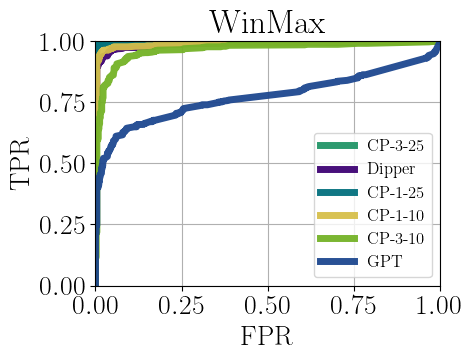

In [9]:
plot_grouped_series_data(
    data_df=df,
    x_col="fpr",
    y_col="tpr",
    x_name="FPR",
    y_name="TPR",
    x_lim=(0,1),
    y_lim=(0,1),
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"WinMax",
    fig_size=(5, 4),
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [10]:
fig_name = "baseline_attacked_retrieval_ROC_T_1000"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,fpr,id,name,tpr
0,7,0.000000,5ez7q3ys,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...,0.000000
1,7,0.000000,5ez7q3ys,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...,0.002000
2,7,0.004000,5ez7q3ys,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...,0.002000
3,7,0.004000,5ez7q3ys,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...,0.008000
4,7,0.006000,5ez7q3ys,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...,0.008000
...,...,...,...,...,...
1724,15,0.965385,plaqii3p,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...,0.994231
1725,15,0.975000,plaqii3p,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...,0.994231
1726,15,0.975000,plaqii3p,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...,0.996154
1727,15,1.000000,plaqii3p,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...,0.996154


['core_simple_1_200_1000_gen_cp_attack_1-10%_prefixes_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_prefixes_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_3-10%_prefixes_eval_supp'
 'core_simple_1_200_1000_no_wm_dipper_high_prefixes_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_prefixes_eval_supp'
 'core_simple_1_200_1000_no_wm_gpt_p4_prefixes_eval_supp']
dict_items([('5ez7q3ys', 'core_simple_1_200_1000_gen_cp_attack_1-10%_prefixes_eval_supp'), ('cdemf9mi', 'core_simple_1_200_1000_gen_cp_attack_1-25%_prefixes_eval_supp'), ('hfp5ofno', 'core_simple_1_200_1000_gen_cp_attack_3-10%_prefixes_eval_supp'), ('mgbk5ci5', 'core_simple_1_200_1000_no_wm_dipper_high_prefixes_eval_supp'), ('n9jnymb9', 'core_simple_1_200_1000_gen_cp_attack_3-25%_prefixes_eval_supp'), ('plaqii3p', 'core_simple_1_200_1000_no_wm_gpt_p4_prefixes_eval_supp')])
Used callable to map series_readable_ids
{'5ez7q3ys': 'CP-1-10%', 'cdemf9mi': 'CP-1-25%', 'hfp5ofno': 'CP-3-10%', 'mgbk5ci5': 'Dipper', 'n9j

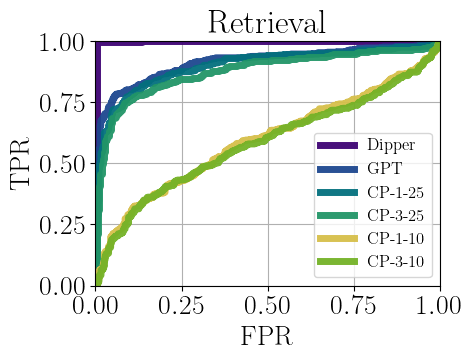

In [11]:
plot_grouped_series_data(
    data_df=df,
    x_col="fpr",
    y_col="tpr",
    x_name="FPR",
    y_name="TPR",
    x_lim=(0,1),
    y_lim=(0,1),
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"Retrieval",
    fig_size=(5, 4),
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [12]:
fig_name = "baseline_attacked_detectgpt_ROC_T_1000"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,fpr,id,name,tpr
0,15,0.000,ab7zh7ta,core_simple_1_200_1000_no_wm_dipper_high_eval_...,0.000
1,15,0.002,ab7zh7ta,core_simple_1_200_1000_no_wm_dipper_high_eval_...,0.000
2,15,0.030,ab7zh7ta,core_simple_1_200_1000_no_wm_dipper_high_eval_...,0.000
3,15,0.030,ab7zh7ta,core_simple_1_200_1000_no_wm_dipper_high_eval_...,0.002
4,15,0.090,ab7zh7ta,core_simple_1_200_1000_no_wm_dipper_high_eval_...,0.002
...,...,...,...,...,...
1631,0,0.996,yeewsgls,core_simple_1_200_1000_no_wm_gpt_p4_eval_supp,0.966
1632,0,0.996,yeewsgls,core_simple_1_200_1000_no_wm_gpt_p4_eval_supp,0.978
1633,0,0.998,yeewsgls,core_simple_1_200_1000_no_wm_gpt_p4_eval_supp,0.978
1634,0,0.998,yeewsgls,core_simple_1_200_1000_no_wm_gpt_p4_eval_supp,1.000


['core_simple_1_200_1000_no_wm_dipper_high_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval_supp'
 'core_simple_1_200_1000_no_wm_gpt_p4_eval_supp']
dict_items([('ab7zh7ta', 'core_simple_1_200_1000_no_wm_dipper_high_eval_supp'), ('dtrrqo1e', 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval_supp'), ('miei424r', 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval_supp'), ('yeewsgls', 'core_simple_1_200_1000_no_wm_gpt_p4_eval_supp')])
Used callable to map series_readable_ids
{'ab7zh7ta': 'Dipper', 'dtrrqo1e': 'CP-3-25%', 'miei424r': 'CP-1-25%', 'yeewsgls': 'GPT'}
[<matplotlib.lines.Line2D object at 0x7f87c936c0a0>, <matplotlib.lines.Line2D object at 0x7f87c936c250>, <matplotlib.lines.Line2D object at 0x7f87c936c4f0>, <matplotlib.lines.Line2D object at 0x7f87c936c790>]
['CP-1-25%', 'CP-3-25%', 'Dipper', 'GPT']


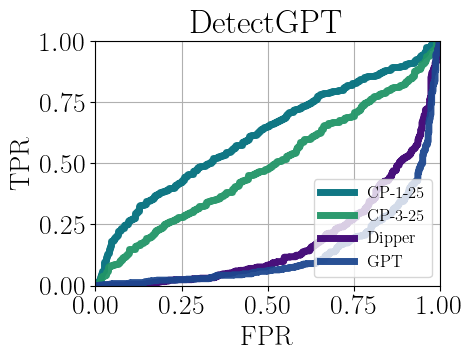

In [13]:
plot_grouped_series_data(
    data_df=df,
    x_col="fpr",
    y_col="tpr",
    x_name="FPR",
    y_name="TPR",
    x_lim=(0,1),
    y_lim=(0,1),
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"DetectGPT",
    fig_size=(5, 4),
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [14]:
fig_name = "baseline_attacked_detectgpt_AUC_at_T_1000"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,aucs,id,idx_T,name
0,15,0.541998,ab7zh7ta,50,core_simple_1_200_1000_no_wm_dipper_high_eval_...
1,15,0.490884,ab7zh7ta,100,core_simple_1_200_1000_no_wm_dipper_high_eval_...
2,15,0.456096,ab7zh7ta,200,core_simple_1_200_1000_no_wm_dipper_high_eval_...
3,15,0.184254,ab7zh7ta,800,core_simple_1_200_1000_no_wm_dipper_high_eval_...
4,14,0.524212,dtrrqo1e,50,core_simple_1_200_1000_gen_cp_attack_3-25%_eva...
5,14,0.554044,dtrrqo1e,100,core_simple_1_200_1000_gen_cp_attack_3-25%_eva...
6,14,0.544540,dtrrqo1e,200,core_simple_1_200_1000_gen_cp_attack_3-25%_eva...
7,14,0.493348,dtrrqo1e,1000,core_simple_1_200_1000_gen_cp_attack_3-25%_eva...
8,13,0.518452,miei424r,50,core_simple_1_200_1000_gen_cp_attack_1-25%_eva...
9,13,0.637336,miei424r,100,core_simple_1_200_1000_gen_cp_attack_1-25%_eva...


['core_simple_1_200_1000_no_wm_dipper_high_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval_supp'
 'core_simple_1_200_1000_no_wm_gpt_p4_eval_supp']
dict_items([('ab7zh7ta', 'core_simple_1_200_1000_no_wm_dipper_high_eval_supp'), ('dtrrqo1e', 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval_supp'), ('miei424r', 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval_supp'), ('yeewsgls', 'core_simple_1_200_1000_no_wm_gpt_p4_eval_supp')])
Used callable to map series_readable_ids
{'ab7zh7ta': 'Dipper', 'dtrrqo1e': 'CP-3-25%', 'miei424r': 'CP-1-25%', 'yeewsgls': 'GPT'}
[<matplotlib.lines.Line2D object at 0x7f87c91f2530>, <matplotlib.lines.Line2D object at 0x7f87c91f2800>, <matplotlib.lines.Line2D object at 0x7f87c91f0f40>, <matplotlib.lines.Line2D object at 0x7f87c91f2b90>]
['GPT', 'CP-1-25%', 'CP-3-25%', 'Dipper']


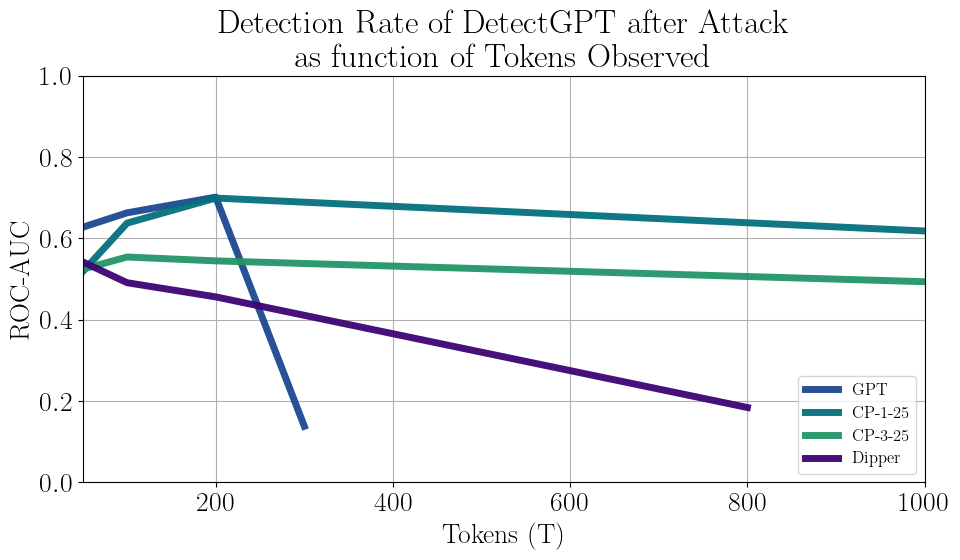

In [15]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="aucs",
    x_name="Tokens (T)",
    y_name="ROC-AUC",
    x_lim=(50,1000),
    y_lim=(0,1),
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"Detection Rate of DetectGPT after Attack\nas function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [16]:
fig_name = "baseline_attacked_retrieval_AUC_at_T_1000"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,aucs,id,idx_T,name
0,7,0.493266,5ez7q3ys,50,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
1,7,0.506631,5ez7q3ys,100,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
2,7,0.517226,5ez7q3ys,150,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
3,7,0.525092,5ez7q3ys,200,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
4,7,0.554276,5ez7q3ys,250,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
...,...,...,...,...,...
115,15,0.941667,plaqii3p,800,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...
116,15,0.941644,plaqii3p,850,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...
117,15,0.941617,plaqii3p,900,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...
118,15,0.941627,plaqii3p,950,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...


['core_simple_1_200_1000_gen_cp_attack_1-10%_prefixes_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_prefixes_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_3-10%_prefixes_eval_supp'
 'core_simple_1_200_1000_no_wm_dipper_high_prefixes_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_prefixes_eval_supp'
 'core_simple_1_200_1000_no_wm_gpt_p4_prefixes_eval_supp']
dict_items([('5ez7q3ys', 'core_simple_1_200_1000_gen_cp_attack_1-10%_prefixes_eval_supp'), ('cdemf9mi', 'core_simple_1_200_1000_gen_cp_attack_1-25%_prefixes_eval_supp'), ('hfp5ofno', 'core_simple_1_200_1000_gen_cp_attack_3-10%_prefixes_eval_supp'), ('mgbk5ci5', 'core_simple_1_200_1000_no_wm_dipper_high_prefixes_eval_supp'), ('n9jnymb9', 'core_simple_1_200_1000_gen_cp_attack_3-25%_prefixes_eval_supp'), ('plaqii3p', 'core_simple_1_200_1000_no_wm_gpt_p4_prefixes_eval_supp')])
Used callable to map series_readable_ids
{'5ez7q3ys': 'CP-1-10%', 'cdemf9mi': 'CP-1-25%', 'hfp5ofno': 'CP-3-10%', 'mgbk5ci5': 'Dipper', 'n9j

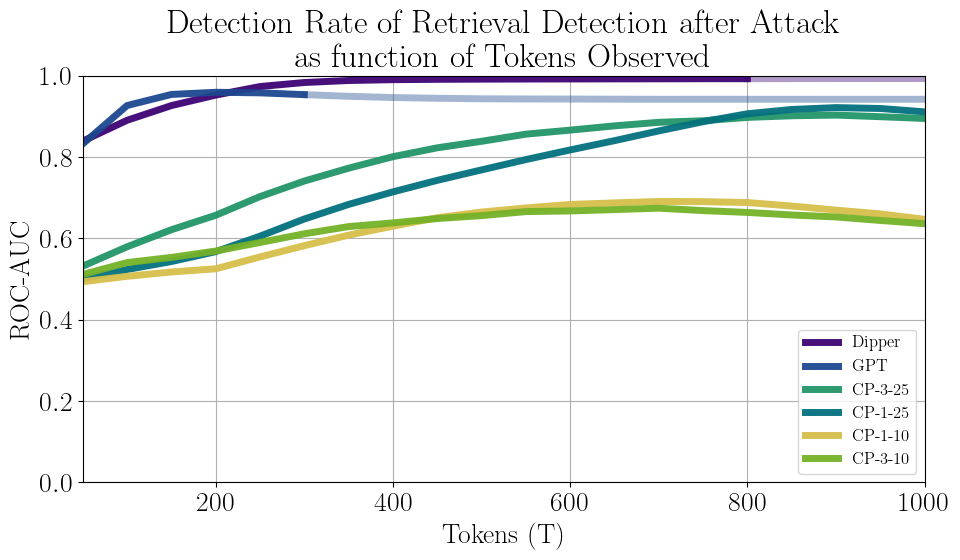

In [17]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="aucs",
    x_name="Tokens (T)",
    y_name="ROC-AUC",
    x_lim=(50,1000),
    y_lim=(0,1),
    limit_x_series_map={"GPT": 300, "Dipper": 800},
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"Detection Rate of Retrieval Detection after Attack\nas function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [18]:
fig_name = "baseline_attacked_z_score_AUC_at_T_1000"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,aucs,id,idx_T,name
0,13,0.530634,sebf8zdh,0,core_simple_1_200_1000_dipper_high_eval
1,13,0.565264,sebf8zdh,1,core_simple_1_200_1000_dipper_high_eval
2,13,0.581183,sebf8zdh,2,core_simple_1_200_1000_dipper_high_eval
3,13,0.594298,sebf8zdh,3,core_simple_1_200_1000_dipper_high_eval
4,13,0.604494,sebf8zdh,4,core_simple_1_200_1000_dipper_high_eval
...,...,...,...,...,...
5986,14,0.874677,321cm0qh,995,core_simple_1_200_1000_gen_cp_attack_3-10%_eval
5987,14,0.873093,321cm0qh,996,core_simple_1_200_1000_gen_cp_attack_3-10%_eval
5988,14,0.870343,321cm0qh,997,core_simple_1_200_1000_gen_cp_attack_3-10%_eval
5989,14,0.843053,321cm0qh,998,core_simple_1_200_1000_gen_cp_attack_3-10%_eval


['core_simple_1_200_1000_dipper_high_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'
 'core_simple_1_200_1000_gpt_p4_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval']
dict_items([('sebf8zdh', 'core_simple_1_200_1000_dipper_high_eval'), ('qlczzu10', 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'), ('uoyt86q9', 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'), ('fai4a3qm', 'core_simple_1_200_1000_gpt_p4_eval'), ('tfo9p2tr', 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'), ('321cm0qh', 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval')])
Used callable to map series_readable_ids
{'sebf8zdh': 'Dipper', 'qlczzu10': 'CP-3-25%', 'uoyt86q9': 'CP-1-25%', 'fai4a3qm': 'GPT', 'tfo9p2tr': 'CP-1-10%', '321cm0qh': 'CP-3-10%'}
[<matplotlib.lines.Line2D object at 0x7f87c915e4a0>, <matplotlib.lines.Line2D object at 0x7f87c915de70>, <matplotlib.lines.Line2D object at 0x7f87c915e35

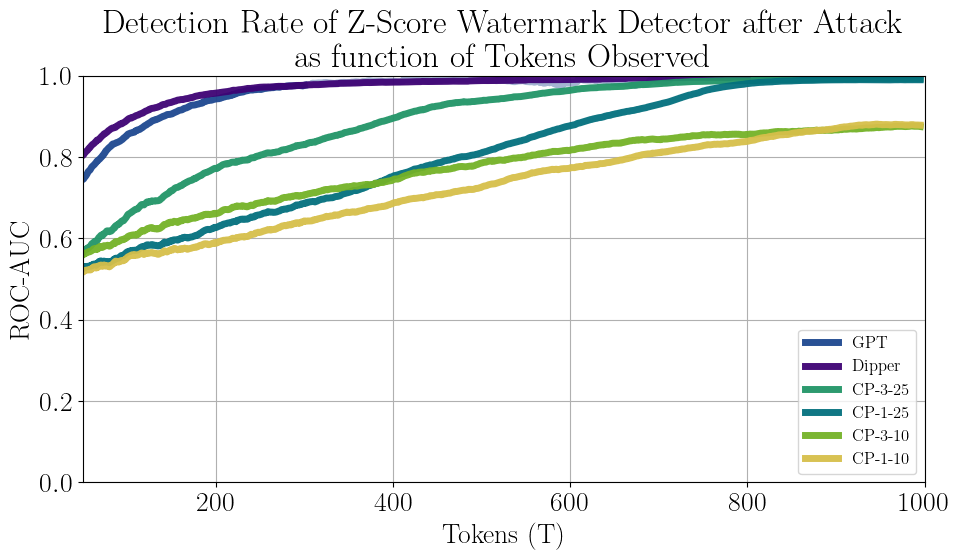

In [19]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="aucs",
    x_name="Tokens (T)",
    y_name="ROC-AUC",
    x_lim=(50,1000),
    y_lim=(0,1),
    limit_x_series=995,
    limit_x_series_map={"GPT": 300, "Dipper": 800},
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"Detection Rate of Z-Score Watermark Detector after Attack\nas function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [20]:
fig_name = "baseline_attacked_winmax_AUC_at_T_1000"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,aucs,id,idx_T,name
0,13,0.493455,sebf8zdh,0,core_simple_1_200_1000_dipper_high_eval
1,13,0.530634,sebf8zdh,1,core_simple_1_200_1000_dipper_high_eval
2,13,0.563727,sebf8zdh,2,core_simple_1_200_1000_dipper_high_eval
3,13,0.576089,sebf8zdh,3,core_simple_1_200_1000_dipper_high_eval
4,13,0.587200,sebf8zdh,4,core_simple_1_200_1000_dipper_high_eval
...,...,...,...,...,...
5986,14,0.966755,321cm0qh,995,core_simple_1_200_1000_gen_cp_attack_3-10%_eval
5987,14,0.966618,321cm0qh,996,core_simple_1_200_1000_gen_cp_attack_3-10%_eval
5988,14,0.969299,321cm0qh,997,core_simple_1_200_1000_gen_cp_attack_3-10%_eval
5989,14,0.968422,321cm0qh,998,core_simple_1_200_1000_gen_cp_attack_3-10%_eval


['core_simple_1_200_1000_dipper_high_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'
 'core_simple_1_200_1000_gpt_p4_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval']
dict_items([('sebf8zdh', 'core_simple_1_200_1000_dipper_high_eval'), ('qlczzu10', 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'), ('uoyt86q9', 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'), ('fai4a3qm', 'core_simple_1_200_1000_gpt_p4_eval'), ('tfo9p2tr', 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'), ('321cm0qh', 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval')])
Used callable to map series_readable_ids
{'sebf8zdh': 'Dipper', 'qlczzu10': 'CP-3-25%', 'uoyt86q9': 'CP-1-25%', 'fai4a3qm': 'GPT', 'tfo9p2tr': 'CP-1-10%', '321cm0qh': 'CP-3-10%'}
[<matplotlib.lines.Line2D object at 0x7f87c900b3d0>, <matplotlib.lines.Line2D object at 0x7f87c9009b10>, <matplotlib.lines.Line2D object at 0x7f87c900b85

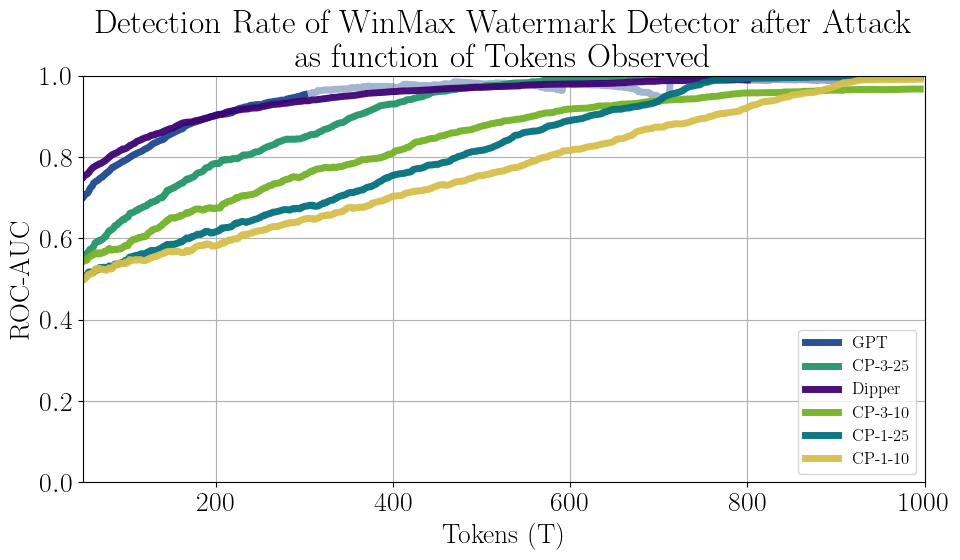

In [21]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="aucs",
    x_name="Tokens (T)",
    y_name="ROC-AUC",
    x_lim=(50,1000),
    y_lim=(0,1),
    limit_x_series=995,
    limit_x_series_map={"GPT": 300, "Dipper": 800},
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"Detection Rate of WinMax Watermark Detector after Attack\nas function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [22]:
# plot score charts

In [23]:
fig_name = "baseline_attacked_retrieval_scores_at_T_1000_base"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,id,idx_T,mean,name
0,7,5ez7q3ys,50,0.063819,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
1,7,5ez7q3ys,100,0.110270,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
2,7,5ez7q3ys,150,0.148034,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
3,7,5ez7q3ys,200,0.181076,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
4,7,5ez7q3ys,250,0.207427,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
...,...,...,...,...,...
115,15,plaqii3p,800,0.286822,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...
116,15,plaqii3p,850,0.286875,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...
117,15,plaqii3p,900,0.286925,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...
118,15,plaqii3p,950,0.286947,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...


['core_simple_1_200_1000_gen_cp_attack_1-10%_prefixes_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_prefixes_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_3-10%_prefixes_eval_supp'
 'core_simple_1_200_1000_no_wm_dipper_high_prefixes_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_prefixes_eval_supp'
 'core_simple_1_200_1000_no_wm_gpt_p4_prefixes_eval_supp']
dict_items([('5ez7q3ys', 'core_simple_1_200_1000_gen_cp_attack_1-10%_prefixes_eval_supp'), ('cdemf9mi', 'core_simple_1_200_1000_gen_cp_attack_1-25%_prefixes_eval_supp'), ('hfp5ofno', 'core_simple_1_200_1000_gen_cp_attack_3-10%_prefixes_eval_supp'), ('mgbk5ci5', 'core_simple_1_200_1000_no_wm_dipper_high_prefixes_eval_supp'), ('n9jnymb9', 'core_simple_1_200_1000_gen_cp_attack_3-25%_prefixes_eval_supp'), ('plaqii3p', 'core_simple_1_200_1000_no_wm_gpt_p4_prefixes_eval_supp')])
Used callable to map series_readable_ids
{'5ez7q3ys': 'CP-1-10%', 'cdemf9mi': 'CP-1-25%', 'hfp5ofno': 'CP-3-10%', 'mgbk5ci5': 'Dipper', 'n9j

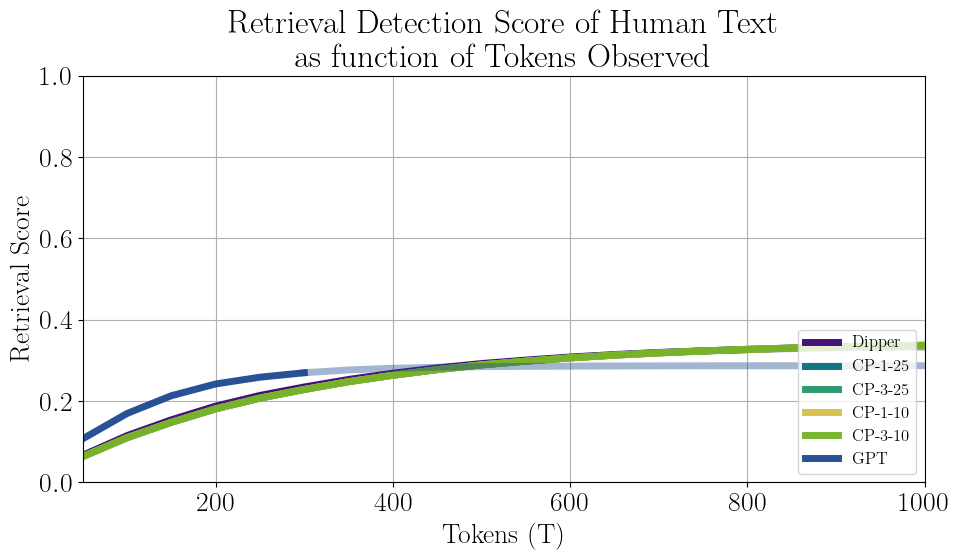

In [24]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="mean",
    x_name="Tokens (T)",
    y_name="Retrieval Score",
    x_lim=(50,1000),
    y_lim=(0,1),
    limit_x_series_map={"GPT": 300, "Dipper": 800},
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"Retrieval Detection Score of Human Text\nas function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [25]:
fig_name = "baseline_attacked_retrieval_scores_at_T_1000_attacked"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,id,idx_T,mean,name
0,7,5ez7q3ys,50,0.056824,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
1,7,5ez7q3ys,100,0.104464,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
2,7,5ez7q3ys,150,0.146198,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
3,7,5ez7q3ys,200,0.182940,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
4,7,5ez7q3ys,250,0.216587,core_simple_1_200_1000_gen_cp_attack_1-10%_pre...
...,...,...,...,...,...
115,15,plaqii3p,800,0.529383,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...
116,15,plaqii3p,850,0.529549,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...
117,15,plaqii3p,900,0.529740,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...
118,15,plaqii3p,950,0.529876,core_simple_1_200_1000_no_wm_gpt_p4_prefixes_e...


['core_simple_1_200_1000_gen_cp_attack_1-10%_prefixes_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_prefixes_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_3-10%_prefixes_eval_supp'
 'core_simple_1_200_1000_no_wm_dipper_high_prefixes_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_prefixes_eval_supp'
 'core_simple_1_200_1000_no_wm_gpt_p4_prefixes_eval_supp']
dict_items([('5ez7q3ys', 'core_simple_1_200_1000_gen_cp_attack_1-10%_prefixes_eval_supp'), ('cdemf9mi', 'core_simple_1_200_1000_gen_cp_attack_1-25%_prefixes_eval_supp'), ('hfp5ofno', 'core_simple_1_200_1000_gen_cp_attack_3-10%_prefixes_eval_supp'), ('mgbk5ci5', 'core_simple_1_200_1000_no_wm_dipper_high_prefixes_eval_supp'), ('n9jnymb9', 'core_simple_1_200_1000_gen_cp_attack_3-25%_prefixes_eval_supp'), ('plaqii3p', 'core_simple_1_200_1000_no_wm_gpt_p4_prefixes_eval_supp')])
Used callable to map series_readable_ids
{'5ez7q3ys': 'CP-1-10%', 'cdemf9mi': 'CP-1-25%', 'hfp5ofno': 'CP-3-10%', 'mgbk5ci5': 'Dipper', 'n9j

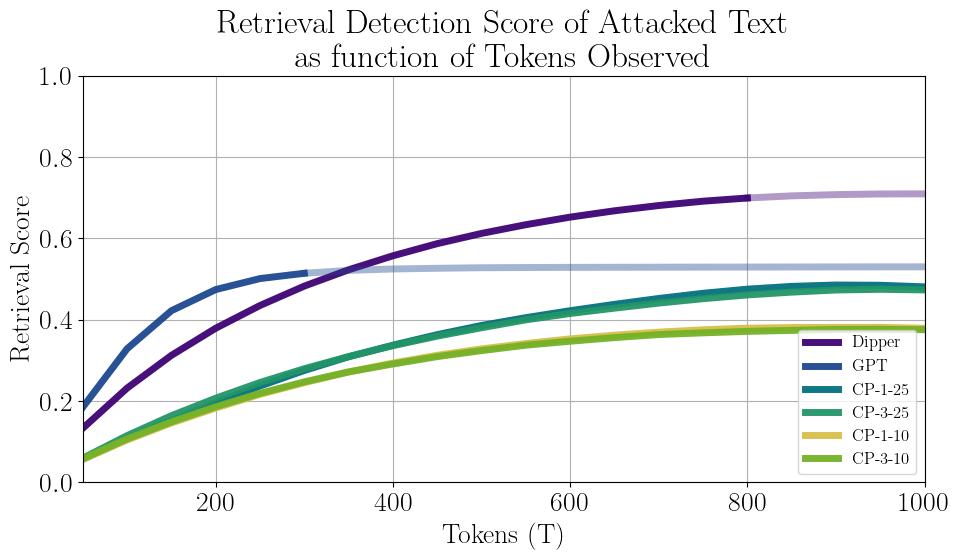

In [26]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="mean",
    x_name="Tokens (T)",
    y_name="Retrieval Score",
    x_lim=(50,1000),
    y_lim=(0,1),
    limit_x_series_map={"GPT": 300, "Dipper": 800},
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"Retrieval Detection Score of Attacked Text\nas function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [27]:
fig_name = "baseline_attacked_detectgpt_scores_at_T_1000_base"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,id,idx_T,mean,name
0,15,ab7zh7ta,50,0.808905,core_simple_1_200_1000_no_wm_dipper_high_eval_...
1,15,ab7zh7ta,100,1.066200,core_simple_1_200_1000_no_wm_dipper_high_eval_...
2,15,ab7zh7ta,200,1.431048,core_simple_1_200_1000_no_wm_dipper_high_eval_...
3,15,ab7zh7ta,800,3.144001,core_simple_1_200_1000_no_wm_dipper_high_eval_...
4,14,dtrrqo1e,50,0.805541,core_simple_1_200_1000_gen_cp_attack_3-25%_eva...
5,14,dtrrqo1e,100,1.072253,core_simple_1_200_1000_gen_cp_attack_3-25%_eva...
6,14,dtrrqo1e,200,1.444406,core_simple_1_200_1000_gen_cp_attack_3-25%_eva...
7,14,dtrrqo1e,1000,3.148789,core_simple_1_200_1000_gen_cp_attack_3-25%_eva...
8,13,miei424r,50,0.810479,core_simple_1_200_1000_gen_cp_attack_1-25%_eva...
9,13,miei424r,100,1.060504,core_simple_1_200_1000_gen_cp_attack_1-25%_eva...


['core_simple_1_200_1000_no_wm_dipper_high_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval_supp'
 'core_simple_1_200_1000_no_wm_gpt_p4_eval_supp']
dict_items([('ab7zh7ta', 'core_simple_1_200_1000_no_wm_dipper_high_eval_supp'), ('dtrrqo1e', 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval_supp'), ('miei424r', 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval_supp'), ('yeewsgls', 'core_simple_1_200_1000_no_wm_gpt_p4_eval_supp')])
Used callable to map series_readable_ids
{'ab7zh7ta': 'Dipper', 'dtrrqo1e': 'CP-3-25%', 'miei424r': 'CP-1-25%', 'yeewsgls': 'GPT'}
[<matplotlib.lines.Line2D object at 0x7f87c83f4340>, <matplotlib.lines.Line2D object at 0x7f87c83f4580>, <matplotlib.lines.Line2D object at 0x7f87c83f48b0>, <matplotlib.lines.Line2D object at 0x7f87c83f4490>]
['CP-3-25%', 'CP-1-25%', 'Dipper', 'GPT']


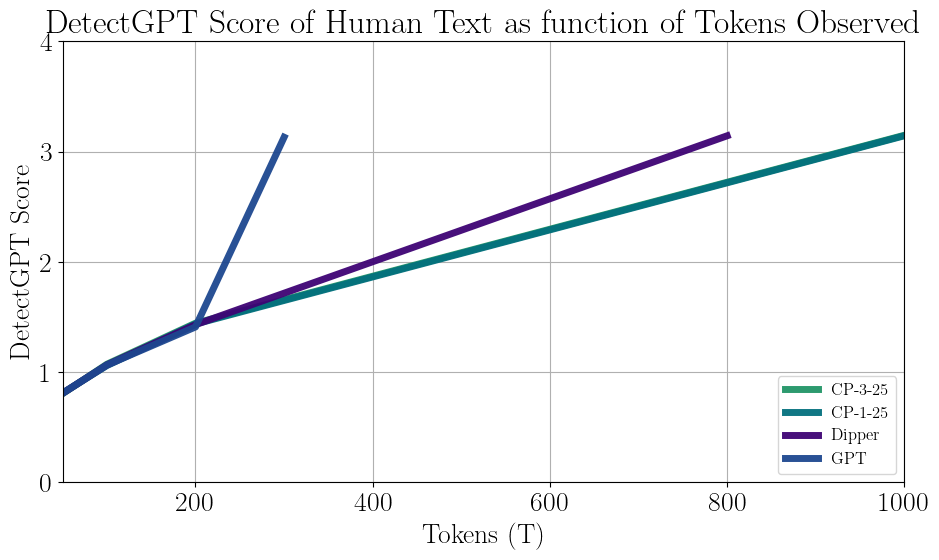

In [28]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="mean",
    x_name="Tokens (T)",
    y_name="DetectGPT Score",
    x_lim=(50,1000),
    y_lim=(0,4),
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"DetectGPT Score of Human Text as function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [29]:
fig_name = "baseline_attacked_detectgpt_scores_at_T_1000_attacked"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,id,idx_T,mean,name
0,15,ab7zh7ta,50,0.865802,core_simple_1_200_1000_no_wm_dipper_high_eval_...
1,15,ab7zh7ta,100,1.050293,core_simple_1_200_1000_no_wm_dipper_high_eval_...
2,15,ab7zh7ta,200,1.362028,core_simple_1_200_1000_no_wm_dipper_high_eval_...
3,15,ab7zh7ta,800,2.352753,core_simple_1_200_1000_no_wm_dipper_high_eval_...
4,14,dtrrqo1e,50,0.813760,core_simple_1_200_1000_gen_cp_attack_3-25%_eva...
5,14,dtrrqo1e,100,1.138531,core_simple_1_200_1000_gen_cp_attack_3-25%_eva...
6,14,dtrrqo1e,200,1.513916,core_simple_1_200_1000_gen_cp_attack_3-25%_eva...
7,14,dtrrqo1e,1000,3.131219,core_simple_1_200_1000_gen_cp_attack_3-25%_eva...
8,13,miei424r,50,0.815771,core_simple_1_200_1000_gen_cp_attack_1-25%_eva...
9,13,miei424r,100,1.217385,core_simple_1_200_1000_gen_cp_attack_1-25%_eva...


['core_simple_1_200_1000_no_wm_dipper_high_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval_supp'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval_supp'
 'core_simple_1_200_1000_no_wm_gpt_p4_eval_supp']
dict_items([('ab7zh7ta', 'core_simple_1_200_1000_no_wm_dipper_high_eval_supp'), ('dtrrqo1e', 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval_supp'), ('miei424r', 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval_supp'), ('yeewsgls', 'core_simple_1_200_1000_no_wm_gpt_p4_eval_supp')])
Used callable to map series_readable_ids
{'ab7zh7ta': 'Dipper', 'dtrrqo1e': 'CP-3-25%', 'miei424r': 'CP-1-25%', 'yeewsgls': 'GPT'}
[<matplotlib.lines.Line2D object at 0x7f87c829cb80>, <matplotlib.lines.Line2D object at 0x7f87c829ce20>, <matplotlib.lines.Line2D object at 0x7f87c829d0c0>, <matplotlib.lines.Line2D object at 0x7f87c829d360>]
['CP-1-25%', 'GPT', 'CP-3-25%', 'Dipper']


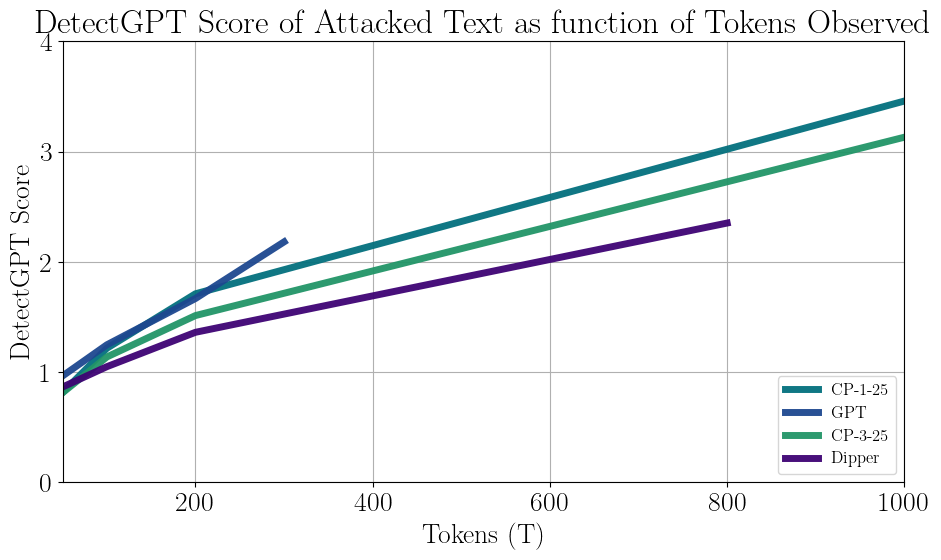

In [30]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="mean",
    x_name="Tokens (T)",
    y_name="DetectGPT Score",
    x_lim=(50,1000),
    y_lim=(0,4),
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"DetectGPT Score of Attacked Text as function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [31]:
fig_name = "baseline_attacked_z_scores_at_T_1000_base"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,avg,id,idx_T,name
0,13,0.017216,sebf8zdh,0,core_simple_1_200_1000_dipper_high_eval
1,13,0.001781,sebf8zdh,1,core_simple_1_200_1000_dipper_high_eval
2,13,-0.020606,sebf8zdh,2,core_simple_1_200_1000_dipper_high_eval
3,13,-0.000840,sebf8zdh,3,core_simple_1_200_1000_dipper_high_eval
4,13,0.033988,sebf8zdh,4,core_simple_1_200_1000_dipper_high_eval
...,...,...,...,...,...
7002,10,0.240709,i136o2qh,996,core_simple_1_200_1000_gen_eval
7003,10,0.240324,i136o2qh,997,core_simple_1_200_1000_gen_eval
7004,10,0.242315,i136o2qh,998,core_simple_1_200_1000_gen_eval
7005,10,0.311337,i136o2qh,999,core_simple_1_200_1000_gen_eval


['core_simple_1_200_1000_dipper_high_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'
 'core_simple_1_200_1000_gpt_p4_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval'
 'core_simple_1_200_1000_gen_eval']
dict_items([('sebf8zdh', 'core_simple_1_200_1000_dipper_high_eval'), ('qlczzu10', 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'), ('uoyt86q9', 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'), ('fai4a3qm', 'core_simple_1_200_1000_gpt_p4_eval'), ('tfo9p2tr', 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'), ('321cm0qh', 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval'), ('i136o2qh', 'core_simple_1_200_1000_gen_eval')])
Used callable to map series_readable_ids
{'sebf8zdh': 'Dipper', 'qlczzu10': 'CP-3-25%', 'uoyt86q9': 'CP-1-25%', 'fai4a3qm': 'GPT', 'tfo9p2tr': 'CP-1-10%', '321cm0qh': 'CP-3-10%', 'i136o2qh': ''}
[<matplotlib.lines.Line2D object at 0x7f87c82bca60>, 

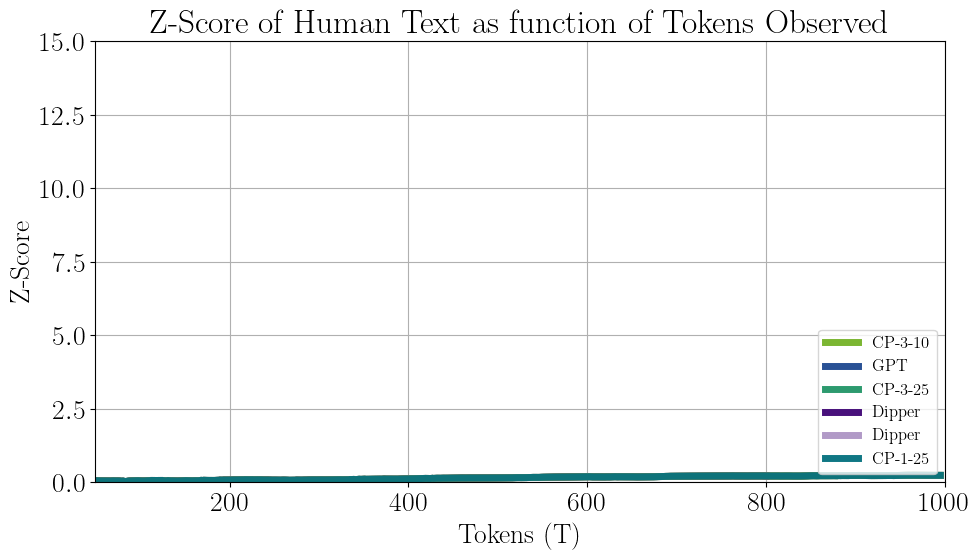

In [32]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="avg",
    x_name="Tokens (T)",
    y_name="Z-Score",
    x_lim=(50,1000),
    y_lim=(0,15),
    limit_x_series=995,
    limit_x_series_map={"GPT": 300, "Dipper": 800},
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"Z-Score of Human Text as function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [33]:
fig_name = "baseline_attacked_z_scores_at_T_1000_attacked"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,avg,id,idx_T,name
0,13,-0.013017,sebf8zdh,0,core_simple_1_200_1000_dipper_high_eval
1,13,0.118169,sebf8zdh,1,core_simple_1_200_1000_dipper_high_eval
2,13,0.234424,sebf8zdh,2,core_simple_1_200_1000_dipper_high_eval
3,13,0.325232,sebf8zdh,3,core_simple_1_200_1000_dipper_high_eval
4,13,0.416801,sebf8zdh,4,core_simple_1_200_1000_dipper_high_eval
...,...,...,...,...,...
6155,14,2.391800,321cm0qh,996,core_simple_1_200_1000_gen_cp_attack_3-10%_eval
6156,14,2.381190,321cm0qh,997,core_simple_1_200_1000_gen_cp_attack_3-10%_eval
6157,14,2.408835,321cm0qh,998,core_simple_1_200_1000_gen_cp_attack_3-10%_eval
6158,14,2.350119,321cm0qh,999,core_simple_1_200_1000_gen_cp_attack_3-10%_eval


['core_simple_1_200_1000_dipper_high_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'
 'core_simple_1_200_1000_gpt_p4_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval']
dict_items([('sebf8zdh', 'core_simple_1_200_1000_dipper_high_eval'), ('qlczzu10', 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'), ('uoyt86q9', 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'), ('fai4a3qm', 'core_simple_1_200_1000_gpt_p4_eval'), ('tfo9p2tr', 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'), ('321cm0qh', 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval')])
Used callable to map series_readable_ids
{'sebf8zdh': 'Dipper', 'qlczzu10': 'CP-3-25%', 'uoyt86q9': 'CP-1-25%', 'fai4a3qm': 'GPT', 'tfo9p2tr': 'CP-1-10%', '321cm0qh': 'CP-3-10%'}
[<matplotlib.lines.Line2D object at 0x7f87c81e5fc0>, <matplotlib.lines.Line2D object at 0x7f87c81e5990>, <matplotlib.lines.Line2D object at 0x7f87c81e5e7

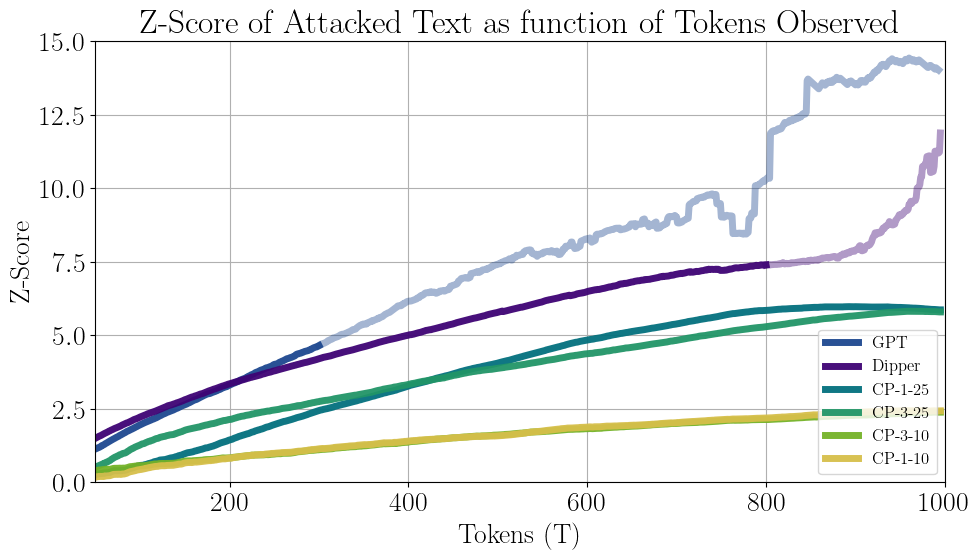

In [34]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="avg",
    x_name="Tokens (T)",
    y_name="Z-Score",
    x_lim=(50,1000),
    y_lim=(0,15),
    limit_x_series=995,
    limit_x_series_map={"GPT": 300, "Dipper": 800},
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"Z-Score of Attacked Text as function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [35]:
fig_name = "baseline_attacked_winmax_scores_at_T_1000_base"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,avg,id,idx_T,name
0,13,0.000000,sebf8zdh,0,core_simple_1_200_1000_dipper_high_eval
1,13,0.445924,sebf8zdh,1,core_simple_1_200_1000_dipper_high_eval
2,13,0.802980,sebf8zdh,2,core_simple_1_200_1000_dipper_high_eval
3,13,1.066178,sebf8zdh,3,core_simple_1_200_1000_dipper_high_eval
4,13,1.310162,sebf8zdh,4,core_simple_1_200_1000_dipper_high_eval
...,...,...,...,...,...
7002,10,3.921619,i136o2qh,996,core_simple_1_200_1000_gen_eval
7003,10,3.921713,i136o2qh,997,core_simple_1_200_1000_gen_eval
7004,10,3.921943,i136o2qh,998,core_simple_1_200_1000_gen_eval
7005,10,3.906037,i136o2qh,999,core_simple_1_200_1000_gen_eval


['core_simple_1_200_1000_dipper_high_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'
 'core_simple_1_200_1000_gpt_p4_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval'
 'core_simple_1_200_1000_gen_eval']
dict_items([('sebf8zdh', 'core_simple_1_200_1000_dipper_high_eval'), ('qlczzu10', 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'), ('uoyt86q9', 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'), ('fai4a3qm', 'core_simple_1_200_1000_gpt_p4_eval'), ('tfo9p2tr', 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'), ('321cm0qh', 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval'), ('i136o2qh', 'core_simple_1_200_1000_gen_eval')])
Used callable to map series_readable_ids
{'sebf8zdh': 'Dipper', 'qlczzu10': 'CP-3-25%', 'uoyt86q9': 'CP-1-25%', 'fai4a3qm': 'GPT', 'tfo9p2tr': 'CP-1-10%', '321cm0qh': 'CP-3-10%', 'i136o2qh': ''}
[<matplotlib.lines.Line2D object at 0x7f87c80c8580>, 

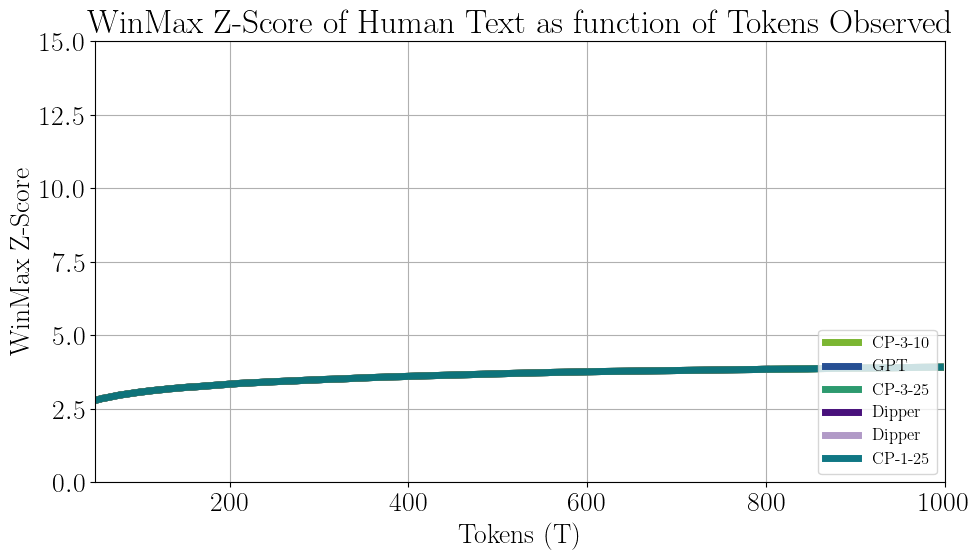

In [36]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="avg",
    x_name="Tokens (T)",
    y_name="WinMax Z-Score",
    x_lim=(50,1000),
    y_lim=(0,15),
    limit_x_series=995,
    limit_x_series_map={"GPT": 300, "Dipper": 800},
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"WinMax Z-Score of Human Text as function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [37]:
fig_name = "baseline_attacked_winmax_scores_at_T_1000_attacked"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,avg,id,idx_T,name
0,13,0.000000,sebf8zdh,0,core_simple_1_200_1000_dipper_high_eval
1,13,0.423250,sebf8zdh,1,core_simple_1_200_1000_dipper_high_eval
2,13,0.915359,sebf8zdh,2,core_simple_1_200_1000_dipper_high_eval
3,13,1.297526,sebf8zdh,3,core_simple_1_200_1000_dipper_high_eval
4,13,1.571870,sebf8zdh,4,core_simple_1_200_1000_dipper_high_eval
...,...,...,...,...,...
6155,14,5.878581,321cm0qh,996,core_simple_1_200_1000_gen_cp_attack_3-10%_eval
6156,14,5.870938,321cm0qh,997,core_simple_1_200_1000_gen_cp_attack_3-10%_eval
6157,14,5.901743,321cm0qh,998,core_simple_1_200_1000_gen_cp_attack_3-10%_eval
6158,14,5.604085,321cm0qh,999,core_simple_1_200_1000_gen_cp_attack_3-10%_eval


['core_simple_1_200_1000_dipper_high_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'
 'core_simple_1_200_1000_gpt_p4_eval'
 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'
 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval']
dict_items([('sebf8zdh', 'core_simple_1_200_1000_dipper_high_eval'), ('qlczzu10', 'core_simple_1_200_1000_gen_cp_attack_3-25%_eval'), ('uoyt86q9', 'core_simple_1_200_1000_gen_cp_attack_1-25%_eval'), ('fai4a3qm', 'core_simple_1_200_1000_gpt_p4_eval'), ('tfo9p2tr', 'core_simple_1_200_1000_gen_cp_attack_1-10%_eval'), ('321cm0qh', 'core_simple_1_200_1000_gen_cp_attack_3-10%_eval')])
Used callable to map series_readable_ids
{'sebf8zdh': 'Dipper', 'qlczzu10': 'CP-3-25%', 'uoyt86q9': 'CP-1-25%', 'fai4a3qm': 'GPT', 'tfo9p2tr': 'CP-1-10%', '321cm0qh': 'CP-3-10%'}
[<matplotlib.lines.Line2D object at 0x7f87c816afb0>, <matplotlib.lines.Line2D object at 0x7f87c816a980>, <matplotlib.lines.Line2D object at 0x7f87c816b31

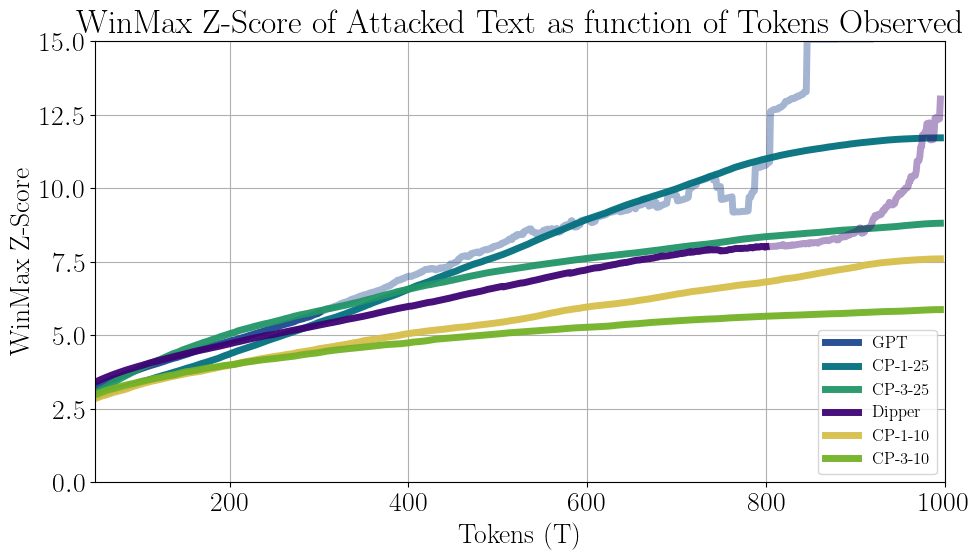

In [38]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="avg",
    x_name="Tokens (T)",
    y_name="WinMax Z-Score",
    x_lim=(50,1000),
    y_lim=(0,15),
    limit_x_series=995,
    limit_x_series_map={"GPT": 300, "Dipper": 800},
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map=color_map,
    sortby="mid",
    legend_loc="lower right",
    title=f"WinMax Z-Score of Attacked Text as function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)